# Feature Reduction Steps:
1. Standardize features by removing the mean and scaling to unit variance
1. Select only 25% the original number of peptides
1. Reduce features with PCA
1. Recursive Feature Elimination
1. Grid Search classifier hyper-parameters

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Classification_Utils as cu
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import time

## Load Dataframe

In [3]:
df = pd.read_csv('..\FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(68623, 253)


## Map each column to a corresponding label

In [3]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [4]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

In [5]:
df.head()

,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW006_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW007_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW008_8Apr16_Arwen_16-01-03,...,Temporal_Lobe_Alz_FX1P159_Guan_1_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_2_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_3_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_1_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_2_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_3_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX2P57_IMAC_153_9May11_Hawk_11-04-02p,Temporal_Lobe_Alz_FX2P57_IMAC_161_20Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_187_26Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_212_11May11_Hawk_11-04-02p
Peptide,,,,,,,,,,,,,,,,,,,,,
-.DIQM*TQSPSTLSASVGDR.V,26.731951,22.187643,3.022208,29.328345,29.916272,3.022208,27.586706,30.458361,29.004130,31.023004,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQM*TQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,30.633308,30.815586,3.022208,29.483431,32.564995,30.319263,32.368436,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDR.V,26.387537,28.015792,3.022208,3.022208,31.403752,3.022208,27.695976,29.779972,29.747784,30.255299,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,3.022208,32.585511,3.022208,3.022208,30.845879,30.983525,27.526416,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.EVQLVETGGGLIQPGGSLR.L,24.546220,3.022208,3.022208,3.022208,26.732727,3.022208,28.163126,23.836245,3.022208,28.436388,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


## Make train-test split

In [6]:
train_df, test_df, train_labels, test_labels = train_test_split(
    df.T, labels, test_size=0.30, 
    random_state=0, 
    stratify=labels)

In [7]:
finalized_model_folder = r'Trained_Models\\'
test_df_path = finalized_model_folder + 'test_df'
joblib.dump(test_df, open(test_df_path, 'wb'))

test_labels_path = finalized_model_folder + 'test_labels'
joblib.dump(test_labels, open(test_labels_path, 'wb'))

## Tune parameters of best models with Grid Search

In [8]:
N_JOBS = 1

from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(random_state=0)

###  Logistic Regression grid search

In [9]:
from sklearn.linear_model import LogisticRegression

SOLVERS = ['liblinear', 'sag', 'saga']
C_OPTIONS = [.01, .1, 1, 10, 100, 1000]
    
lr_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('select_features', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', LogisticRegression(random_state=0))])


lr_param_grid = {
    'classify__solver': SOLVERS,
    'classify__C': C_OPTIONS
}

lr_grid = GridSearchCV(lr_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=lr_param_grid)
                       
lr_grid.fit(train_df, train_labels)

print('Best Logistic Regression parameters:\n', lr_grid.best_params_)
print('\nBest Cross-Validation score:\n', lr_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   544   569   579   610   733   746   806   907  1150  1688
  1791  1914  1925  2083  2149  2159  2170  2257  2280  2290  2305  2335
  2458  2469  2702  2712  2856  2988  3035  3038  3288  3411  3505  3590
  3689  3692  3747  3802  4104  4123  4157  4203  4371  4634  6016  6478
  6821  7516  7705  7881  8816  9371  9574 10327 12834 14282 14499 14779
 15596 16305 16509 17163 18008 18126 19079 19081 19401 19438 19876 21411
 21728 22716 23309 23972 26043 26102 26200 26560 27486 27722 28381 28399
 28413 28614 29426 29754 29880 30915 31978 32277 32282 33143 33670 34591
 35088 35107 35191 35249 35301 35322 35373 35582 35603 35658 35670 35674
 35824 3583

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  143   579   746   767   780   926  1107  1533  2257  2280  2283  2351
  2363  2469  2527  2702  2876  3035  3117  3206  3258  3457  3567  4547
  4823  5420  6112  6408  7009  7164  7632  9065  9926 10327 10473 11662
 11753 12533 12573 13093 13570 13785 13822 14123 14770 15102 15799 15899
 16359 17492 17794 17948 18652 19106 19203 19401 19641 20426 20611 21182
 21591 22244 23955 24446 24786 24816 25001 25040 26043 26233 28718 29754
 29828 29870 30162 30289 32282 32671 33784 34350 34966 35029 35033 35059
 35513 35605 35623 35644 35729 35747 35782 35834 35849 35852 36020 36130
 36388 36616 36938 37097 37491 38236 38466 39550 39655 39657 40004 40593
 40701 40891 40904 41047 41249 42112 42250 42367 42721 43091 43278 43355
 43524 43836 43888 44124 44792 45301 45872 46155 46817 47595 47893 48164
 48165 48328 48375 48585 48647 48654 49454 49499 49850 51517 51935 52572
 529

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  122   393   579   716   870   881   933  1348  1473  1533  1537  1547
  1674  1703  1839  1972  2019  2140  2176  2257  2280  2305  2415  2437
  2440  2469  2527  2561  2702  2716  2755  2756  2876  2915  3035  3083
  3218  3703  5392  5431  5653  6101  6221  6503  6843  6902  6996  7008
  7128  7164  7420  7494  8476  8680  9047  9406  9739  9748  9755  9927
 10318 10327 10338 10340 11967 12268 12533 12566 13093 13358 13383 13416
 13587 13669 13896 14043 14123 14148 14176 14560 14715 14770 15010 15050
 15156 15293 15358 16119 16941 17794 17880 18581 18605 18652 19057 19131
 19203 19401 19455 20005 20221 20680 21182 21549 21709 23164 23564 23568
 23662 2395

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  401   579   790   926  1250  1341  1839  1845  1972  2019  2140  2257
  2280  2440  2469  2561  2702  2769  2867  2876  3035  3117  3457  3547
  3787  3913  4365  4513  4557  5098  5373  6408  6441  6638  6652  6673
  6675  6799  6974  6984  7164  7757  8705  8990  9008  9041  9072  9200
  9506 10199 10333 10372 10876 11662 11707 11848 12011 12467 12533 12671
 12847 13035 13372 13963 14026 14043 14055 14123 14327 14480 14668 14803
 15351 15526 15593 15799 16067 16271 16496 16556 16564 16570 16643 17011
 17288 17445 17692 18248 18652 19057 19203 19392 19401 19540 19571 19780
 20431 20631 20665 20724 20742 20790 21299 21631 21819 21879 22329 22956
 23925 2395

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   569   579   632   639   640   733   926  1364  1451  1475
  1478  1631  1697  1698  1717  1791  1914  1925  2004  2083  2118  2149
  2155  2257  2280  2290  2335  2370  2390  2458  2469  2702  2712  2852
  3035  3117  3214  3288  3457  3590  3600  3689  4104  4123  4157  4203
  4356  4634  5471  5884  6433  6509  6638  6713  7372  7467  7743  8018
  8936  9574  9703 10876 11707 11791 12227 12467 12834 12873 12910 13587
 13631 14120 14196 14483 14815 14874 15080 15156 15251 15593 17599 17623
 18008 18470 19057 19099 19401 19790 21728 21879 23309 23381 23925 24168
 25803 25805 26064 27120 27207 28008 28159 28304 28589 28614 28718 29088
 29860 29972 30297 30982 31664 32003 32282 33582 33921 34233 34890 34952
 35088 35107 35249 35301 35582 35603 35658 35670 35671 35674 35834 35852
 35878 35911 36078 36130 36214 36310 36523 36527 36561 36627 36644 36666
 371

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  401   579   790   926  1250  1341  1839  1845  1972  2019  2140  2257
  2280  2440  2469  2561  2702  2769  2867  2876  3035  3117  3457  3547
  3787  3913  4365  4513  4557  5098  5373  6408  6441  6638  6652  6673
  6675  6799  6974  6984  7164  7757  8705  8990  9008  9041  9072  9200
  9506 10199 10333 10372 10876 11662 11707 11848 12011 12467 12533 12671
 12847 13035 13372 13963 14026 14043 14055 14123 14327 14480 14668 14803
 15351 15526 15593 15799 16067 16271 16496 16556 16564 16570 16643 17011
 17288 17445 17692 18248 18652 19057 19203 19392 19401 19540 19571 19780
 20431 20631 20665 20724 20742 20790 21299 21631 21819 21879 22329 22956
 23925 23955 24200 24577 24786 24798 24822 24964 25135 25159 25335 26064
 26233 26589 27442 27477 27515 28159 28399 28589 28718 28807 29292 29460
 29740 29828 30698 30935 31275 31323 31388 32234 32282 32322 34222 34233
 344

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   569   579   632   639   640   733   926  1364  1451  1475
  1478  1631  1697  1698  1717  1791  1914  1925  2004  2083  2118  2149
  2155  2257  2280  2290  2335  2370  2390  2458  2469  2702  2712  2852
  3035  3117  3214  3288  3457  3590  3600  3689  4104  4123  4157  4203
  4356  4634  5471  5884  6433  6509  6638  6713  7372  7467  7743  8018
  8936  9574  9703 10876 11707 11791 12227 12467 12834 12873 12910 13587
 13631 14120 14196 14483 14815 14874 15080 15156 15251 15593 17599 17623
 18008 18470 19057 19099 19401 19790 21728 21879 23309 23381 23925 24168
 25803 25805 26064 27120 27207 28008 28159 28304 28589 28614 28718 29088
 29860 2997

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   167   351   401   511   579   640   881   922  1012  1247  1451
  1631  1640  1674  1720  1750  1758  1780  1819  1873  1899  1910  1935
  1943  1948  1952  2105  2135  2159  2207  2246  2257  2259  2280  2347
  2446  2469  2532  2575  2594  2624  2635  2668  2702  2705  2852  3035
  3218  5140  5300  5653  7313  7467  7734  7743  7881  8031  8502  9748
  9878 10111 10287 10340 10981 11675 12554 12714 13027 13332 13333 14079
 14176 14386 14781 15010 15293 16613 17988 19240 19339 19401 19438 19838
 19876 20153 20589 20642 20801 22275 22351 22699 22941 23499 23564 23683
 23972 24105 24163 24824 25215 26262 26619 26771 26967 27042 27121 27573
 28381 29166 29467 29828 29880 30109 30323 30635 30686 31289 31610 32003
 32226 32232 32282 32355 32908 33003 33143 33984 34529 34842 35145 35154
 35164 35216 35249 35259 35355 35364 35445 35495 35511 35575 35591 35652
 356

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  392   393   579   870  1160  1258  1469  1473  1533  1674  1703  1831
  1839  2019  2140  2252  2257  2280  2305  2415  2440  2469  2527  2554
  2561  2615  2702  2716  2755  2756  2774  3035  3083  3182  3711  3913
  4011  4055  4448  4947  5761  5876  5995  6137  6221  6294  6442  6503
  6509  6918  6939  6957  6996  7008  7039  7128  7140  7420  7494  7787
  7995  8216  8476  8680  9047  9406  9584  9703  9755  9915  9927 10327
 10403 10722 11247 12075 12543 12566 12948 13017 13333 13358 13440 13896
 14298 14560 14770 15050 15358 15384 15387 16036 16664 16743 16805 16941
 17000 17367 17661 17680 17794 17880 18008 18520 18581 18931 19087 19131
 19401 1945

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 3557

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   95   148   220   392   579   647   716   926  1674  1756  2257  2280
  2469  2702  2988  3035  3218  3913  4390  4652  5653  5884  6441  6582
  6673  6799  6843  6957  6984  7467  8680  9008  9045  9095  9200  9506
 10327 10587 10840 11400 12492 12671 13896 13914 13915 13963 14560 15306
 15756 16073 16137 16578 17288 17810 18008 19023 19401 19581 19665 20724
 20742 21631 21819 23564 24105 24431 24786 24936 25803 26043 26064 26233
 26422 26534 26633 27442 29150 29860 31155 32232 32282 32438 32685 33501
 33981 34529 35259 35328 35834 35852 35944 36139 36337 36616 36819 37188
 37327 37462 38007 38253 38466 38743 39083 39092 39211 39464 40593 40852
 41021 41108 41249 41365 41565 42042 42528 43026 44731 46222 46695 46746
 47010 47519 48152 48558 48665 48941 49110 49557 49604 50108 50992 53339
 53526 53666 54017 54097 55010 55327 56056 57959 58202 58227 58411 59176
 592

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   544   569   579   610   733   746   806   907  1150  1688
  1791  1914  1925  2083  2149  2159  2170  2257  2280  2290  2305  2335
  2458  2469  2702  2712  2856  2988  3035  3038  3288  3411  3505  3590
  3689  3692  3747  3802  4104  4123  4157  4203  4371  4634  6016  6478
  6821  7516  7705  7881  8816  9371  9574 10327 12834 14282 14499 14779
 15596 16305 16509 17163 18008 18126 19079 19081 19401 19438 19876 21411
 21728 22716 23309 23972 26043 26102 26200 26560 27486 27722 28381 28399
 28413 28614 29426 29754 29880 30915 31978 32277 32282 33143 33670 34591
 35088 35107 35191 35249 35301 35322 35373 35582 35603 35658 35670 35674
 35824 35834 35852 35911 36133 36139 36214 36366 36561 36616 36877 36913
 37108 38007 38065 38271 38713 40336 40355 40356 41249 41691 44767 45872
 46218 48077 51056 51603 51844 53139 53534 54059 54636 55324 57108 57471
 580

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   95   148   220   392   579   647   716   926  1674  1756  2257  2280
  2469  2702  2988  3035  3218  3913  4390  4652  5653  5884  6441  6582
  6673  6799  6843  6957  6984  7467  8680  9008  9045  9095  9200  9506
 10327 10587 10840 11400 12492 12671 13896 13914 13915 13963 14560 15306
 15756 16073 16137 16578 17288 17810 18008 19023 19401 19581 19665 20724
 20742 21631 21819 23564 24105 24431 24786 24936 25803 26043 26064 26233
 26422 26534 26633 27442 29150 29860 31155 32232 32282 32438 32685 33501
 33981 34529 35259 35328 35834 35852 35944 36139 36337 36616 36819 37188
 37327 37462 38007 38253 38466 38743 39083 39092 39211 39464 40593 40852
 41021 41108 41249 41365 41565 42042 42528 43026 44731 46222 46695 46746
 47010 47519 48152 48558 48665 48941 49110 49557 49604 50108 50992 53339
 53526 53666 54017 54097 55010 55327 56056 57959 58202 58227 58411 59176
 592

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   544   569   579   610   733   746   806   907  1150  1688
  1791  1914  1925  2083  2149  2159  2170  2257  2280  2290  2305  2335
  2458  2469  2702  2712  2856  2988  3035  3038  3288  3411  3505  3590
  3689  3692  3747  3802  4104  4123  4157  4203  4371  4634  6016  6478
  6821  7516  7705  7881  8816  9371  9574 10327 12834 14282 14499 14779
 15596 16305 16509 17163 18008 18126 19079 19081 19401 19438 19876 21411
 21728 22716 23309 23972 26043 26102 26200 26560 27486 27722 28381 28399
 28413 28614 29426 29754 29880 30915 31978 32277 32282 33143 33670 34591
 35088 35107 35191 35249 35301 35322 35373 35582 35603 35658 35670 35674
 35824 3583

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  143   579   746   767   780   926  1107  1533  2257  2280  2283  2351
  2363  2469  2527  2702  2876  3035  3117  3206  3258  3457  3567  4547
  4823  5420  6112  6408  7009  7164  7632  9065  9926 10327 10473 11662
 11753 12533 12573 13093 13570 13785 13822 14123 14770 15102 15799 15899
 16359 17492 17794 17948 18652 19106 19203 19401 19641 20426 20611 21182
 21591 22244 23955 24446 24786 24816 25001 25040 26043 26233 28718 29754
 29828 29870 30162 30289 32282 32671 33784 34350 34966 35029 35033 35059
 35513 35605 35623 35644 35729 35747 35782 35834 35849 35852 36020 36130
 36388 36616 36938 37097 37491 38236 38466 39550 39655 39657 40004 40593
 40701 40891 40904 41047 41249 42112 42250 42367 42721 43091 43278 43355
 43524 43836 43888 44124 44792 45301 45872 46155 46817 47595 47893 48164
 48165 48328 48375 48585 48647 48654 49454 49499 49850 51517 51935 52572
 529

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  122   393   579   716   870   881   933  1348  1473  1533  1537  1547
  1674  1703  1839  1972  2019  2140  2176  2257  2280  2305  2415  2437
  2440  2469  2527  2561  2702  2716  2755  2756  2876  2915  3035  3083
  3218  3703  5392  5431  5653  6101  6221  6503  6843  6902  6996  7008
  7128  7164  7420  7494  8476  8680  9047  9406  9739  9748  9755  9927
 10318 10327 10338 10340 11967 12268 12533 12566 13093 13358 13383 13416
 13587 13669 13896 14043 14123 14148 14176 14560 14715 14770 15010 15050
 15156 15293 15358 16119 16941 17794 17880 18581 18605 18652 19057 19131
 19203 19401 19455 20005 20221 20680 21182 21549 21709 23164 23564 23568
 23662 2395

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  401   579   790   926  1250  1341  1839  1845  1972  2019  2140  2257
  2280  2440  2469  2561  2702  2769  2867  2876  3035  3117  3457  3547
  3787  3913  4365  4513  4557  5098  5373  6408  6441  6638  6652  6673
  6675  6799  6974  6984  7164  7757  8705  8990  9008  9041  9072  9200
  9506 10199 10333 10372 10876 11662 11707 11848 12011 12467 12533 12671
 12847 13035 13372 13963 14026 14043 14055 14123 14327 14480 14668 14803
 15351 15526 15593 15799 16067 16271 16496 16556 16564 16570 16643 17011
 17288 17445 17692 18248 18652 19057 19203 19392 19401 19540 19571 19780
 20431 20631 20665 20724 20742 20790 21299 21631 21819 21879 22329 22956
 23925 2395

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   569   579   632   639   640   733   926  1364  1451  1475
  1478  1631  1697  1698  1717  1791  1914  1925  2004  2083  2118  2149
  2155  2257  2280  2290  2335  2370  2390  2458  2469  2702  2712  2852
  3035  3117  3214  3288  3457  3590  3600  3689  4104  4123  4157  4203
  4356  4634  5471  5884  6433  6509  6638  6713  7372  7467  7743  8018
  8936  9574  9703 10876 11707 11791 12227 12467 12834 12873 12910 13587
 13631 14120 14196 14483 14815 14874 15080 15156 15251 15593 17599 17623
 18008 18470 19057 19099 19401 19790 21728 21879 23309 23381 23925 24168
 25803 25805 26064 27120 27207 28008 28159 28304 28589 28614 28718 29088
 29860 29972 30297 30982 31664 32003 32282 33582 33921 34233 34890 34952
 35088 35107 35249 35301 35582 35603 35658 35670 35671 35674 35834 35852
 35878 35911 36078 36130 36214 36310 36523 36527 36561 36627 36644 36666
 371

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  401   579   790   926  1250  1341  1839  1845  1972  2019  2140  2257
  2280  2440  2469  2561  2702  2769  2867  2876  3035  3117  3457  3547
  3787  3913  4365  4513  4557  5098  5373  6408  6441  6638  6652  6673
  6675  6799  6974  6984  7164  7757  8705  8990  9008  9041  9072  9200
  9506 10199 10333 10372 10876 11662 11707 11848 12011 12467 12533 12671
 12847 13035 13372 13963 14026 14043 14055 14123 14327 14480 14668 14803
 15351 15526 15593 15799 16067 16271 16496 16556 16564 16570 16643 17011
 17288 17445 17692 18248 18652 19057 19203 19392 19401 19540 19571 19780
 20431 20631 20665 20724 20742 20790 21299 21631 21819 21879 22329 22956
 23925 23955 24200 24577 24786 24798 24822 24964 25135 25159 25335 26064
 26233 26589 27442 27477 27515 28159 28399 28589 28718 28807 29292 29460
 29740 29828 30698 30935 31275 31323 31388 32234 32282 32322 34222 34233
 344

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   569   579   632   639   640   733   926  1364  1451  1475
  1478  1631  1697  1698  1717  1791  1914  1925  2004  2083  2118  2149
  2155  2257  2280  2290  2335  2370  2390  2458  2469  2702  2712  2852
  3035  3117  3214  3288  3457  3590  3600  3689  4104  4123  4157  4203
  4356  4634  5471  5884  6433  6509  6638  6713  7372  7467  7743  8018
  8936  9574  9703 10876 11707 11791 12227 12467 12834 12873 12910 13587
 13631 14120 14196 14483 14815 14874 15080 15156 15251 15593 17599 17623
 18008 18470 19057 19099 19401 19790 21728 21879 23309 23381 23925 24168
 25803 25805 26064 27120 27207 28008 28159 28304 28589 28614 28718 29088
 29860 2997

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   167   351   401   511   579   640   881   922  1012  1247  1451
  1631  1640  1674  1720  1750  1758  1780  1819  1873  1899  1910  1935
  1943  1948  1952  2105  2135  2159  2207  2246  2257  2259  2280  2347
  2446  2469  2532  2575  2594  2624  2635  2668  2702  2705  2852  3035
  3218  5140  5300  5653  7313  7467  7734  7743  7881  8031  8502  9748
  9878 10111 10287 10340 10981 11675 12554 12714 13027 13332 13333 14079
 14176 14386 14781 15010 15293 16613 17988 19240 19339 19401 19438 19838
 19876 20153 20589 20642 20801 22275 22351 22699 22941 23499 23564 23683
 23972 24105 24163 24824 25215 26262 26619 26771 26967 27042 27121 27573
 28381 29166 29467 29828 29880 30109 30323 30635 30686 31289 31610 32003
 32226 32232 32282 32355 32908 33003 33143 33984 34529 34842 35145 35154
 35164 35216 35249 35259 35355 35364 35445 35495 35511 35575 35591 35652
 356

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  392   393   579   870  1160  1258  1469  1473  1533  1674  1703  1831
  1839  2019  2140  2252  2257  2280  2305  2415  2440  2469  2527  2554
  2561  2615  2702  2716  2755  2756  2774  3035  3083  3182  3711  3913
  4011  4055  4448  4947  5761  5876  5995  6137  6221  6294  6442  6503
  6509  6918  6939  6957  6996  7008  7039  7128  7140  7420  7494  7787
  7995  8216  8476  8680  9047  9406  9584  9703  9755  9915  9927 10327
 10403 10722 11247 12075 12543 12566 12948 13017 13333 13358 13440 13896
 14298 14560 14770 15050 15358 15384 15387 16036 16664 16743 16805 16941
 17000 17367 17661 17680 17794 17880 18008 18520 18581 18931 19087 19131
 19401 1945

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 3557

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   95   148   220   392   579   647   716   926  1674  1756  2257  2280
  2469  2702  2988  3035  3218  3913  4390  4652  5653  5884  6441  6582
  6673  6799  6843  6957  6984  7467  8680  9008  9045  9095  9200  9506
 10327 10587 10840 11400 12492 12671 13896 13914 13915 13963 14560 15306
 15756 16073 16137 16578 17288 17810 18008 19023 19401 19581 19665 20724
 20742 21631 21819 23564 24105 24431 24786 24936 25803 26043 26064 26233
 26422 26534 26633 27442 29150 29860 31155 32232 32282 32438 32685 33501
 33981 34529 35259 35328 35834 35852 35944 36139 36337 36616 36819 37188
 37327 37462 38007 38253 38466 38743 39083 39092 39211 39464 40593 40852
 41021 41108 41249 41365 41565 42042 42528 43026 44731 46222 46695 46746
 47010 47519 48152 48558 48665 48941 49110 49557 49604 50108 50992 53339
 53526 53666 54017 54097 55010 55327 56056 57959 58202 58227 58411 59176
 592

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   544   569   579   610   733   746   806   907  1150  1688
  1791  1914  1925  2083  2149  2159  2170  2257  2280  2290  2305  2335
  2458  2469  2702  2712  2856  2988  3035  3038  3288  3411  3505  3590
  3689  3692  3747  3802  4104  4123  4157  4203  4371  4634  6016  6478
  6821  7516  7705  7881  8816  9371  9574 10327 12834 14282 14499 14779
 15596 16305 16509 17163 18008 18126 19079 19081 19401 19438 19876 21411
 21728 22716 23309 23972 26043 26102 26200 26560 27486 27722 28381 28399
 28413 28614 29426 29754 29880 30915 31978 32277 32282 33143 33670 34591
 35088 35107 35191 35249 35301 35322 35373 35582 35603 35658 35670 35674
 35824 35834 35852 35911 36133 36139 36214 36366 36561 36616 36877 36913
 37108 38007 38065 38271 38713 40336 40355 40356 41249 41691 44767 45872
 46218 48077 51056 51603 51844 53139 53534 54059 54636 55324 57108 57471
 580

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   95   148   220   392   579   647   716   926  1674  1756  2257  2280
  2469  2702  2988  3035  3218  3913  4390  4652  5653  5884  6441  6582
  6673  6799  6843  6957  6984  7467  8680  9008  9045  9095  9200  9506
 10327 10587 10840 11400 12492 12671 13896 13914 13915 13963 14560 15306
 15756 16073 16137 16578 17288 17810 18008 19023 19401 19581 19665 20724
 20742 21631 21819 23564 24105 24431 24786 24936 25803 26043 26064 26233
 26422 26534 26633 27442 29150 29860 31155 32232 32282 32438 32685 33501
 33981 34529 35259 35328 35834 35852 35944 36139 36337 36616 36819 37188
 37327 37462 38007 38253 38466 38743 39083 39092 39211 39464 40593 40852
 41021 41108 41249 41365 41565 42042 42528 43026 44731 46222 46695 46746
 47010 47519 48152 48558 48665 48941 49110 49557 49604 50108 50992 53339
 53526 53666 54017 54097 55010 55327 56056 57959 58202 58227 58411 59176
 592

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   544   569   579   610   733   746   806   907  1150  1688
  1791  1914  1925  2083  2149  2159  2170  2257  2280  2290  2305  2335
  2458  2469  2702  2712  2856  2988  3035  3038  3288  3411  3505  3590
  3689  3692  3747  3802  4104  4123  4157  4203  4371  4634  6016  6478
  6821  7516  7705  7881  8816  9371  9574 10327 12834 14282 14499 14779
 15596 16305 16509 17163 18008 18126 19079 19081 19401 19438 19876 21411
 21728 22716 23309 23972 26043 26102 26200 26560 27486 27722 28381 28399
 28413 28614 29426 29754 29880 30915 31978 32277 32282 33143 33670 34591
 35088 35107 35191 35249 35301 35322 35373 35582 35603 35658 35670 35674
 35824 3583

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  143   579   746   767   780   926  1107  1533  2257  2280  2283  2351
  2363  2469  2527  2702  2876  3035  3117  3206  3258  3457  3567  4547
  4823  5420  6112  6408  7009  7164  7632  9065  9926 10327 10473 11662
 11753 12533 12573 13093 13570 13785 13822 14123 14770 15102 15799 15899
 16359 17492 17794 17948 18652 19106 19203 19401 19641 20426 20611 21182
 21591 22244 23955 24446 24786 24816 25001 25040 26043 26233 28718 29754
 29828 29870 30162 30289 32282 32671 33784 34350 34966 35029 35033 35059
 35513 35605 35623 35644 35729 35747 35782 35834 35849 35852 36020 36130
 36388 36616 36938 37097 37491 38236 38466 39550 39655 39657 40004 40593
 40701 40891 40904 41047 41249 42112 42250 42367 42721 43091 43278 43355
 43524 43836 43888 44124 44792 45301 45872 46155 46817 47595 47893 48164
 48165 48328 48375 48585 48647 48654 49454 49499 49850 51517 51935 52572
 529

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  122   393   579   716   870   881   933  1348  1473  1533  1537  1547
  1674  1703  1839  1972  2019  2140  2176  2257  2280  2305  2415  2437
  2440  2469  2527  2561  2702  2716  2755  2756  2876  2915  3035  3083
  3218  3703  5392  5431  5653  6101  6221  6503  6843  6902  6996  7008
  7128  7164  7420  7494  8476  8680  9047  9406  9739  9748  9755  9927
 10318 10327 10338 10340 11967 12268 12533 12566 13093 13358 13383 13416
 13587 13669 13896 14043 14123 14148 14176 14560 14715 14770 15010 15050
 15156 15293 15358 16119 16941 17794 17880 18581 18605 18652 19057 19131
 19203 19401 19455 20005 20221 20680 21182 21549 21709 23164 23564 23568
 23662 2395

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  401   579   790   926  1250  1341  1839  1845  1972  2019  2140  2257
  2280  2440  2469  2561  2702  2769  2867  2876  3035  3117  3457  3547
  3787  3913  4365  4513  4557  5098  5373  6408  6441  6638  6652  6673
  6675  6799  6974  6984  7164  7757  8705  8990  9008  9041  9072  9200
  9506 10199 10333 10372 10876 11662 11707 11848 12011 12467 12533 12671
 12847 13035 13372 13963 14026 14043 14055 14123 14327 14480 14668 14803
 15351 15526 15593 15799 16067 16271 16496 16556 16564 16570 16643 17011
 17288 17445 17692 18248 18652 19057 19203 19392 19401 19540 19571 19780
 20431 20631 20665 20724 20742 20790 21299 21631 21819 21879 22329 22956
 23925 2395

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   569   579   632   639   640   733   926  1364  1451  1475
  1478  1631  1697  1698  1717  1791  1914  1925  2004  2083  2118  2149
  2155  2257  2280  2290  2335  2370  2390  2458  2469  2702  2712  2852
  3035  3117  3214  3288  3457  3590  3600  3689  4104  4123  4157  4203
  4356  4634  5471  5884  6433  6509  6638  6713  7372  7467  7743  8018
  8936  9574  9703 10876 11707 11791 12227 12467 12834 12873 12910 13587
 13631 14120 14196 14483 14815 14874 15080 15156 15251 15593 17599 17623
 18008 18470 19057 19099 19401 19790 21728 21879 23309 23381 23925 24168
 25803 25805 26064 27120 27207 28008 28159 28304 28589 28614 28718 29088
 29860 29972 30297 30982 31664 32003 32282 33582 33921 34233 34890 34952
 35088 35107 35249 35301 35582 35603 35658 35670 35671 35674 35834 35852
 35878 35911 36078 36130 36214 36310 36523 36527 36561 36627 36644 36666
 371

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  401   579   790   926  1250  1341  1839  1845  1972  2019  2140  2257
  2280  2440  2469  2561  2702  2769  2867  2876  3035  3117  3457  3547
  3787  3913  4365  4513  4557  5098  5373  6408  6441  6638  6652  6673
  6675  6799  6974  6984  7164  7757  8705  8990  9008  9041  9072  9200
  9506 10199 10333 10372 10876 11662 11707 11848 12011 12467 12533 12671
 12847 13035 13372 13963 14026 14043 14055 14123 14327 14480 14668 14803
 15351 15526 15593 15799 16067 16271 16496 16556 16564 16570 16643 17011
 17288 17445 17692 18248 18652 19057 19203 19392 19401 19540 19571 19780
 20431 20631 20665 20724 20742 20790 21299 21631 21819 21879 22329 22956
 23925 23955 24200 24577 24786 24798 24822 24964 25135 25159 25335 26064
 26233 26589 27442 27477 27515 28159 28399 28589 28718 28807 29292 29460
 29740 29828 30698 30935 31275 31323 31388 32234 32282 32322 34222 34233
 344

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   148   569   579   632   639   640   733   926  1364  1451  1475
  1478  1631  1697  1698  1717  1791  1914  1925  2004  2083  2118  2149
  2155  2257  2280  2290  2335  2370  2390  2458  2469  2702  2712  2852
  3035  3117  3214  3288  3457  3590  3600  3689  4104  4123  4157  4203
  4356  4634  5471  5884  6433  6509  6638  6713  7372  7467  7743  8018
  8936  9574  9703 10876 11707 11791 12227 12467 12834 12873 12910 13587
 13631 14120 14196 14483 14815 14874 15080 15156 15251 15593 17599 17623
 18008 18470 19057 19099 19401 19790 21728 21879 23309 23381 23925 24168
 25803 25805 26064 27120 27207 28008 28159 28304 28589 28614 28718 29088
 29860 2997

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  130   167   351   401   511   579   640   881   922  1012  1247  1451
  1631  1640  1674  1720  1750  1758  1780  1819  1873  1899  1910  1935
  1943  1948  1952  2105  2135  2159  2207  2246  2257  2259  2280  2347
  2446  2469  2532  2575  2594  2624  2635  2668  2702  2705  2852  3035
  3218  5140  5300  5653  7313  7467  7734  7743  7881  8031  8502  9748
  9878 10111 10287 10340 10981 11675 12554 12714 13027 13332 13333 14079
 14176 14386 14781 15010 15293 16613 17988 19240 19339 19401 19438 19838
 19876 20153 20589 20642 20801 22275 22351 22699 22941 23499 23564 23683
 23972 24105 24163 24824 25215 26262 26619 26771 26967 27042 27121 27573
 28381 29166 29467 29828 29880 30109 30323 30635 30686 31289 31610 32003
 32226 32232 32282 32355 32908 33003 33143 33984 34529 34842 35145 35154
 35164 35216 35249 35259 35355 35364 35445 35495 35511 35575 35591 35652
 356

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  392   393   579   870  1160  1258  1469  1473  1533  1674  1703  1831
  1839  2019  2140  2252  2257  2280  2305  2415  2440  2469  2527  2554
  2561  2615  2702  2716  2755  2756  2774  3035  3083  3182  3711  3913
  4011  4055  4448  4947  5761  5876  5995  6137  6221  6294  6442  6503
  6509  6918  6939  6957  6996  7008  7039  7128  7140  7420  7494  7787
  7995  8216  8476  8680  9047  9406  9584  9703  9755  9915  9927 10327
 10403 10722 11247 12075 12543 12566 12948 13017 13333 13358 13440 13896
 14298 14560 14770 15050 15358 15384 15387 16036 16664 16743 16805 16941
 17000 17367 17661 17680 17794 17880 18008 18520 18581 18931 19087 19131
 19401 1945

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 3557

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   95   148   220   392   579   647   716   926  1674  1756  2257  2280
  2469  2702  2988  3035  3218  3913  4390  4652  5653  5884  6441  6582
  6673  6799  6843  6957  6984  7467  8680  9008  9045  9095  9200  9506
 10327 10587 10840 11400 12492 12671 13896 13914 13915 13963 14560 15306
 15756 16073 16137 16578 17288 17810 18008 19023 19401 19581 19665 20724
 20742 21631 21819 23564 24105 24431 24786 24936 25803 26043 26064 26233
 26422 26534 26633 27442 29150 29860 31155 32232 32282 32438 32685 33501
 33981 34529 35259 35328 35834 35852 35944 36139 36337 36616 36819 37188
 37327 37462 38007 38253 38466 38743 39083 39092 39211 39464 40593 40852
 41021 41108 41249 41365 41565 42042 42528 43026 44731 46222 46695 46746
 47010 47519 48152 48558 48665 48941 49110 49557 49604 50108 50992 53339
 53526 53666 54017 54097 55010 55327 56056 57959 58202 58227 58411 59176
 592

Best Logistic Regression parameters:
 {'classify__C': 10, 'classify__solver': 'liblinear'}

Best Cross-Validation score:
 0.9796296296296296


In [10]:
finalized_model_folder = r'Trained_Models\\'
model_path = finalized_model_folder + 'lr_grid.sav'
joblib.dump(lr_grid, open(model_path, 'wb'))

### Random Forest grid search

In [11]:
MAX_FEATURES = ['auto', 'sqrt', 'log2']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5, 10]
N_ESTIMATORS = [25, 50, 100, 200]

rf_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', RandomForestClassifier(random_state=0))])

    
rf_param_grid = {
    'classify__n_estimators': N_ESTIMATORS,
    'classify__min_samples_split': MIN_SAMPLES_SPLIT,
    'classify__max_features': MAX_FEATURES
}

rf_grid = GridSearchCV(rf_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=rf_param_grid)

rf_grid.fit(train_df, train_labels)

print('Best Random Forest parameters:\n', rf_grid.best_params_)
print('\nBest Cross-Validation score:\n', rf_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  579  2257  2280  2469  2702  3035 19401 32282 35834 35852 67907 68289
 68310 68457] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Random Forest parameters:
 {'classify__max_features': 'auto', 'classify__min_samples_split': 3, 'classify__n_estimators': 200}

Best Cross-Validation score:
 0.9814814814814815


In [12]:
model_path = finalized_model_folder + 'rf_grid.sav'
joblib.dump(rf_grid, open(model_path, 'wb'))

### SVC grid search

In [13]:
from sklearn.svm import SVC

KERNELS = ['linear', 'rbf', 'poly']

svc_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', SVC(probability=True, random_state=0))])
 
svc_param_grid = {
    'classify__kernel': KERNELS,
    'classify__C': C_OPTIONS
}

svc_grid = GridSearchCV(svc_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=svc_param_grid)

svc_grid.fit(train_df, train_labels)

print('Best SVC parameters:\n', svc_grid.best_params_)
print('\nBest Cross-Validation score:\n', svc_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  579  2257  2280  2469  2702  3035 19401 32282 35834 35852 67907 68289
 68310 68457] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best SVC parameters:
 {'classify__C': 0.01, 'classify__kernel': 'linear'}

Best Cross-Validation score:
 0.9777777777777777


In [14]:
model_path = finalized_model_folder + 'svc_grid.sav'
joblib.dump(svc_grid, open(model_path, 'wb'))

### KNN grid search

In [15]:
from sklearn.neighbors import KNeighborsClassifier

KERNELS = ['linear', 'rbf', 'poly']

knn_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', KNeighborsClassifier())])
 
N_NEIGHBORS = [1, 3, 5, 10, 20]
 
knn_param_grid = {
    'classify__n_neighbors': N_NEIGHBORS
}

knn_grid = GridSearchCV(knn_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=knn_param_grid)

knn_grid.fit(train_df, train_labels)

print('Best KNN parameters:\n', knn_grid.best_params_)
print('\nBest Cross-Validation score:\n', knn_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  579  2257  2280  2469  2702  3035 19401 32282 35834 35852 67907 68289
 68310 68457] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best KNN parameters:
 {'classify__n_neighbors': 1}

Best Cross-Validation score:
 0.9648148148148148


In [16]:
model_path = finalized_model_folder + 'knn_grid.sav'
joblib.dump(knn_grid, open(model_path, 'wb'))

### Multinomial Naive Bayes grid search

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

mnb_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('scale', MinMaxScaler()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', MultinomialNB())])
 
ALPHAS = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
 
mnb_param_grid = {
    'classify__alpha': ALPHAS
}

mnb_grid = GridSearchCV(mnb_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=mnb_param_grid)

mnb_grid.fit(train_df, train_labels)

print('Best Multinomial NB parameters:\n', mnb_grid.best_params_)
print('\nBest Cross-Validation score:\n', mnb_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  579  2257  2280  2469  2702  3035 19401 32282 35834 35852 67907 68289
 68310 68457] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Multinomial NB parameters:
 {'classify__alpha': 0.001}

Best Cross-Validation score:
 0.9037037037037037


In [18]:
model_path = finalized_model_folder + 'mnb_grid.sav'
joblib.dump(mnb_grid, open(model_path, 'wb'))

### Gaussian Naive Bayes - no hyper-parameters to tune

In [19]:
from sklearn.naive_bayes import GaussianNB

gnb_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', GaussianNB())])

gnb_pipe.fit(train_df, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  579  2257  2280  2469  2702  3035 19401 32282 35834 35852 67907 68289
 68310 68457] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', SelectPercentile(percentile=25,
         score_func=<function f_classif at 0x000000C576298A60>)), ('reduce_features', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_sol...art=False),
  n_features_to_select=None, step=1, verbose=0)), ('classify', GaussianNB(priors=None))])

In [20]:
model_path = finalized_model_folder + 'gnb_25P_PCA_RFE.sav'
joblib.dump(gnb_pipe, open(model_path, 'wb'))

### Gradient Boosting grid search

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', GradientBoostingClassifier(random_state=0))])
 
MAX_DEPTH = range(5,16,3)
    
gbc_param_grid = {
    'classify__n_estimators': N_ESTIMATORS,
    'classify__min_samples_split': MIN_SAMPLES_SPLIT,
    'classify__max_depth': MAX_DEPTH 
}

gbc_grid = GridSearchCV(gbc_pipe, 
                       cv=cv, 
                       n_jobs=N_JOBS, 
                       param_grid=gbc_param_grid)

gbc_grid.fit(train_df, train_labels)

print('Best Gradient Boosting parameters:\n', gbc_grid.best_params_)
print('\nBest Cross-Validation score:\n', gbc_grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  569   579   733   871  1160  1533  1791  1914  1925  2083  2149  2257
  2280  2290  2335  2458  2465  2469  2702  2712  2876  2898  3035  3182
  3288  3590  3689  3837  4104  4123  4634  4794  4947  5431  6137  6962
  7164  8816  8980 10327 10722 12582 12834 12962 13440 13733 14123 14770
 15010 15994 16509 16805 17680 18441 18652 18931 19087 19203 19401 19790
 19988 21182 21591 21728 23182 23309 23955 25040 26043 26628 26733 26866
 27173 27963 28399 28614 28939 30073 31477 31610 32275 32282 34350 35088
 35107 35301 35582 35603 35658 35670 35674 35729 35747 35834 35849 35852
 35911 36616 36647 36666 36852 36911 37358 38240 38568 39740 40453 40629
 41121 41249 42203 43524 44205 44621 44700 44976 45629 47155 48973 49135
 49367 50504 51187 51603 51879 53363 53407 53469 54087 54767 55324 55880
 55995 57108 57355 57508 57520 58692 59490 59641 59920 60374 60438 60533
 609

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  167   313   441   579   871  1606  1750  1758  1819  1844  1859  1935
  1943  1948  1972  1991  2019  2115  2135  2140  2246  2257  2280  2296
  2323  2387  2407  2440  2446  2469  2470  2521  2561  2575  2624  2654
  2668  2702  2955  2980  3035  3411  3772  3787  5140  7785  9026  9079
 10327 10771 11353 11674 12631 13527 13619 14480 15627 16033 16509 16613
 16993 17794 17934 17941 18248 18436 18719 19240 19401 19475 19742 20928
 21898 22335 22941 23261 23467 23499 23683 24302 24725 26043 26102 26589
 26716 26967 27121 28187 29467 29828 30323 30502 30686 31102 31483 32282
 32299 32355 32933 33670 34222 34291 34591 34974 35147 35164 35216 35364
 35373 35575 35652 35676 35774 35834 35840 35852 35928 36251 36300 36318
 36389 36616 36850 36923 36927 37171 38065 38450 39161 39410 39595 39891
 39908 41147 41249 41501 41833 42112 43649 43850 44210 45008 45053 45965
 472

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  579  2257  2280  2469  2702  3035 19401 32282 35834 35852 67907 68289
 68310 68457] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Gradient Boosting parameters:
 {'classify__max_depth': 5, 'classify__min_samples_split': 10, 'classify__n_estimators': 50}

Best Cross-Validation score:
 0.9333333333333333


In [22]:
model_path = finalized_model_folder + 'gbc_grid.sav'
joblib.dump(gbc_grid, open(model_path, 'wb'))

## Classify Training Set

In [23]:
lr_grid_pred = lr_grid.predict(test_df)
lr_grid_result = lr_grid.score(test_df, test_labels)

rf_grid_pred = rf_grid.predict(test_df)
rf_grid_result = rf_grid.score(test_df, test_labels)

svc_grid_pred = svc_grid.predict(test_df)
svc_grid_result = svc_grid.score(test_df, test_labels)

knn_grid_pred = knn_grid.predict(test_df)
knn_grid_result = knn_grid.score(test_df, test_labels)

mnb_grid_pred = mnb_grid.predict(test_df)
mnb_grid_result = mnb_grid.score(test_df, test_labels)

gnb_grid_pred = gnb_pipe.predict(test_df)
gnb_grid_result = gnb_pipe.score(test_df, test_labels)

gbc_grid_pred = gbc_grid.predict(test_df)
gbc_grid_result = gbc_grid.score(test_df, test_labels)

In [24]:
print(lr_grid_result)
print(rf_grid_result)
print(svc_grid_result)
print(knn_grid_result)
print(gnb_grid_result)
print(mnb_grid_result)
print(gbc_grid_result)

1.0
1.0
1.0
1.0
0.5921052631578947
0.9605263157894737
0.9736842105263158


##  Confusion matrices of model's predictions on new data

Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 9]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


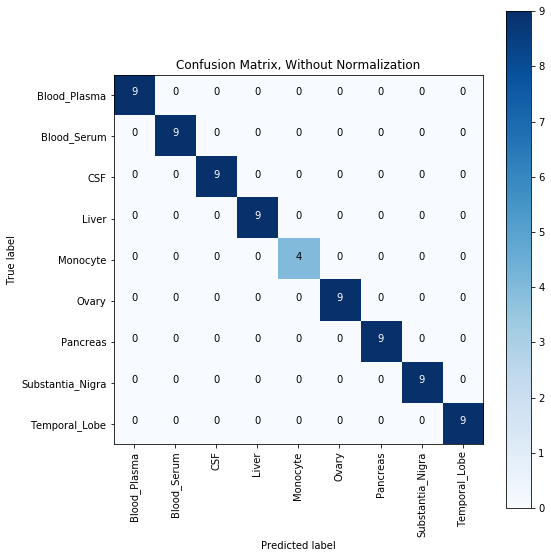

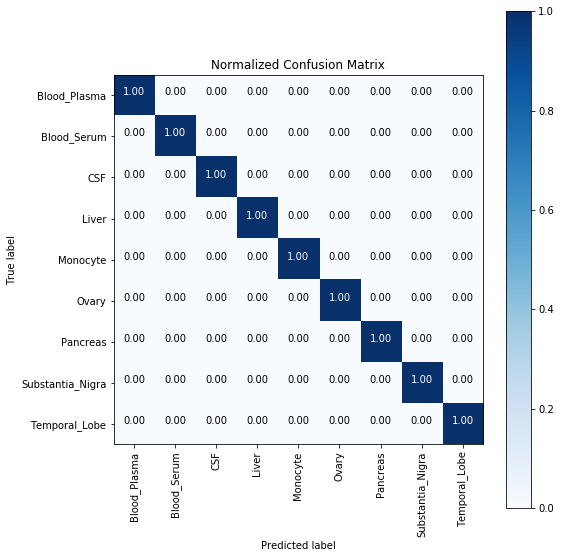

In [25]:
cu.show_confusion_matrices(test_labels, svc_grid_pred, tissues)